## Лабораторная работа №7
### Краевые задачи для дифференциального уравнения эллиптического типа

Сорокин Никита, М8О-403Б-20

### Задание
Решить краевую задачу для дифференциального уравнения эллиптического типа. Аппроксимацию уравнения произвести с использованием центрально-разностной схемы. Для решения дискретного аналога применить следующие методы: метод простых итераций (метод Либмана), метод Зейделя, метод простых итераций с верхней релаксацией. Вычислить погрешность численного решения путем сравнения результатов с приведенным в задании аналитическим решением $U(x, y)$.

Вариант 2:

$$
\begin{cases}
\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}= 0 \\
u_x(0, y) = 0  \\
u(1, y) = 1 - y^2 \\
u_y(x, 0) = 0   \\
u(x, 1) = x^2 - 1
\end{cases}
$$

Аналитическое решение: 

$$
U(x, y) = x^2 - y^2
$$

In [1]:
import sys 
sys.path

sys.path.insert(0, r"c:\Users\никита\Desktop\учеба\чм\modules")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
sns.set()

%matplotlib widget

plt.rcParams["figure.figsize"] = (10, 6)

import LinearAlgebra

In [3]:
x_begin = 0
x_end = 1

y_begin = 0
y_end = 1

h_x = 0.05
h_y = 0.05

Начальные условия:

In [4]:
def phi_1(y):
    return 0

def phi_2(y):
    return 1 - y**2

def phi_3(x):
    return 0

def phi_4(x):
    return x**2 - 1

def solution(x, y):
    return x**2 - y**2

### Точное решение

In [5]:
def get_analytical_solution(x_begin, x_end, y_begin, y_end, h_x, h_y):

    x = np.arange(x_begin, x_end + h_x, h_x)
    y = np.arange(y_begin, y_end + h_y, h_y)

    u = np.zeros((x.size, y.size))
    for i in range(x.size):
        for j in range(y.size):
            u[i, j] = solution(x[i], y[j])
    
    return u

In [6]:
u_exact = get_analytical_solution(x_begin, x_end, y_begin, y_end, h_x, h_y)

### Конечно-разностная схема

В исходном уравнении перейдем от производных к их численным приближениям. 
Получим соотношение:


$$
\frac{u_{i+1,j} - 2 u_{i,j} + u_{i-1, j}}{h_1^2} + \frac{u_{i, j+1} - 2 u_{i, j} + u_{i, j+1}}{h_2^2} = f(x_i, y_j) + O(h_1^2 + h_2^2) \\[6pt]
$$

$ h_1 = h_2:$
$$
u_{i, j} = \frac{1}{4} \Big( u_{i + 1, j} + u_{i - 1, j} + u_{i, j + 1} +  u_{i, j - 1} - h^2 \, f_{i, j} \Big) \\
$$

$ h_1 \neq h_2:$
$$
u_{i,j} = \frac{h_1^2}{2(h_1^2+h_2^2)} (u_{i,j+1} + u_{i, j-1}) +  \frac{h_2^2}{2(h_1^2+h_2^2)}  (u_{i+1, j} + u_{i-1, j}) - h_1  h_2  \, f_{i, j} \\[6pt]
$$

Записав такое соотношение для всех $i, \, j $, получим систему уравнений. Решить ее можно итерационными способами.


### Начальная интерполяция

Так как граничные условия без производных относятся не к противоположным стенкам граничной области, начальная интерполяция задается следующим образом:

$$
u = \phi_2(y) \cdot \frac{1 - y}{(1 - x) + (1 - y)} + \phi_4(x) \cdot \frac{1 - x}{(1 - x) + (1 - y)}
$$

In [9]:
def linear_interpolation(x_begin, x_end, y_begin, y_end, h_x, h_y):

    x = np.arange(x_begin, x_end + h_x, h_x)    
    y = np.arange(y_begin, y_end + h_y, h_y)    

    u = np.zeros((x.size, y.size))

    eps = 0.1

    for i in range(x.size):
        for j in range(y.size):
            u[i, j] = (phi_2(y[j]) * (1 - y[j]) / ((1 - x[i]) + (1 - y[j]) + eps)
                       + phi_4(x[i]) * (1 - x[i]) / ((1 - x[i]) + (1 - y[j]) + eps))

    return u

In [11]:
def finite_difference_scheme(x_begin, x_end, y_begin, y_end, h_x, h_y, method, eps=1, c=0):
    
    x = np.arange(x_begin, x_end + h_x, h_x)    
    y = np.arange(y_begin, y_end + h_y, h_y)    

    u = np.zeros((x.size, y.size))

    equations_n = (x.size - 2) * (y.size - 2)
    A = np.zeros((equations_n, equations_n))
    b = np.zeros((equations_n))

    for k in range(equations_n):

        # corner points

        if k == 0:
            A[k, k] = h_x**2 + h_y**2 - 2 * (h_x**2 + h_y**2)
            A[k, k + 1] = h_x**2
            A[k, k + (y.size - 2)] = h_y**2
            continue

        if k == (y.size - 3):
            A[k, k] = h_y**2 - 2 * (h_x**2 + h_y**2)
            A[k, k - 1] = h_x**2
            A[k, k + (y.size - 2)] = h_y**2
            b[k] = -h_x**2 * phi_4(x[k // (y.size - 2)])
            continue

        if k == equations_n - 1 - (y.size - 3):
            A[k, k] = h_x**2 - 2 * (h_x**2 + h_y**2)
            A[k, k + 1] = h_x**2
            A[k, k - (y.size - 2)] = h_y**2
            b[k] = -h_x**2 * phi_2(y[k % (y.size - 2)]) 
            continue

        if k == equations_n - 1:
            A[k, k] = - 2 * (h_x**2 + h_y**2)
            A[k, k - 1] = h_x**2
            A[k, k - (y.size - 2)] = h_y**2
            b[k] = -h_y**2 * phi_2(y[k % (y.size - 2)]) - h_x**2 * phi_4(x[k // (y.size - 2)])
            continue

        # boundary points

        if k <= (y.size - 3): 
            A[k, k] = h_y**2 - 2 * (h_x**2 + h_y**2)
            A[k, k + 1] = h_x**2
            A[k, k - 1] = h_x**2
            A[k, k + (y.size - 2)] = h_y**2
            continue

        if k >= equations_n - (y.size - 2):
            A[k, k] = -2 * (h_x**2 + h_y**2)
            A[k, k + 1] = h_x**2
            A[k, k - 1] = h_x**2
            A[k, k - (y.size - 2)] = h_y**2
            b[k] = -h_y**2 * phi_2(y[k % (y.size - 2)])
            continue

        if k % (y.size - 2) == 0:
            A[k, k] = h_x**2 - 2 * (h_x**2 + h_y**2)
            A[k, k + 1] = h_x**2
            A[k, k - (y.size - 2)] = h_y**2
            A[k, k + (y.size - 2)] = h_y**2
            continue

        if k % (y.size - 2) == (y.size - 3):
            A[k, k] = -2 * (h_x**2 + h_y**2)
            A[k, k - 1] = h_x**2
            A[k, k - (y.size - 2)] = h_y**2
            A[k, k + (y.size - 2)] = h_y**2
            b[k] = -h_x**2 * phi_4(x[k // (y.size - 2)])
            continue

        # inner points

        A[k, k] = -2 * (h_x**2 + h_y**2)
        A[k, k + 1] = h_x**2
        A[k, k - 1] = h_x**2
        A[k, k - (y.size - 2)] = h_y**2
        A[k, k + (y.size - 2)] = h_y**2

    
    u_0 = linear_interpolation(x_begin, x_end, y_begin, y_end, h_x, h_y)
    u = np.copy(u_0)

    #return u_0
    
    u_0_vector = u_0[1:-1, 1:-1].reshape(equations_n)

    if method == np.linalg.solve:
        u_vector = method(A, b)
        k = 0
    else: 
        u_vector, k = method(A, b, eps, u_0_vector, c)

    u[1:-1, 1:-1] = u_vector.reshape((x.size - 2, y.size - 2))
    
    u[:, 0] = u[:, 1]
    u[0, :] = u[1, :]
    u[:, -1] = phi_4(x[:])
    u[-1, :] = phi_2(y[:])

    return u, k

### Полученные результаты

In [12]:
def plot_surface(u_exact, u):
    x = np.arange(x_begin, x_end + h_x, h_x)
    y = np.arange(y_begin, y_end + h_y, h_y)
    x, y = np.meshgrid(x, y)

    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
    ax.set_ylabel('x')
    ax.set_xlabel('y')
    surf1 = ax.plot_surface(x, y, u_exact, color='red')
    surf2 = ax.plot_surface(x, y, u)

    ax.legend()
    plt.show()

In [13]:
u_exact = get_analytical_solution(x_begin, x_end, y_begin, y_end, h_x, h_y)

In [14]:
method = np.linalg.solve

u_np, k_np = finite_difference_scheme(x_begin, x_end, y_begin, y_end, h_x, h_y, method)

In [15]:
method = LinearAlgebra.simple_iterations_method
с = 0
eps = 1e-5

u_iterations, k_iterations = finite_difference_scheme(x_begin, x_end, y_begin, y_end, h_x, h_y, method, eps)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


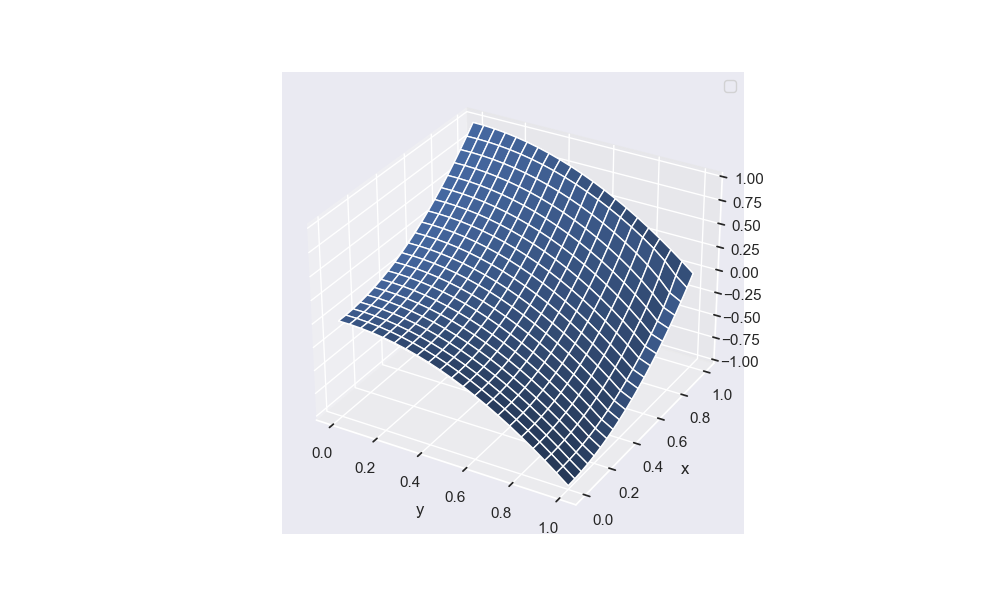

In [16]:
plot_surface(u_exact, u_iterations)

In [17]:
method = LinearAlgebra.Seidel_method
c = 0
eps = 1e-5

u_seidel, k_seidel = finite_difference_scheme(x_begin, x_end, y_begin, y_end, h_x, h_y, method, eps, c)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


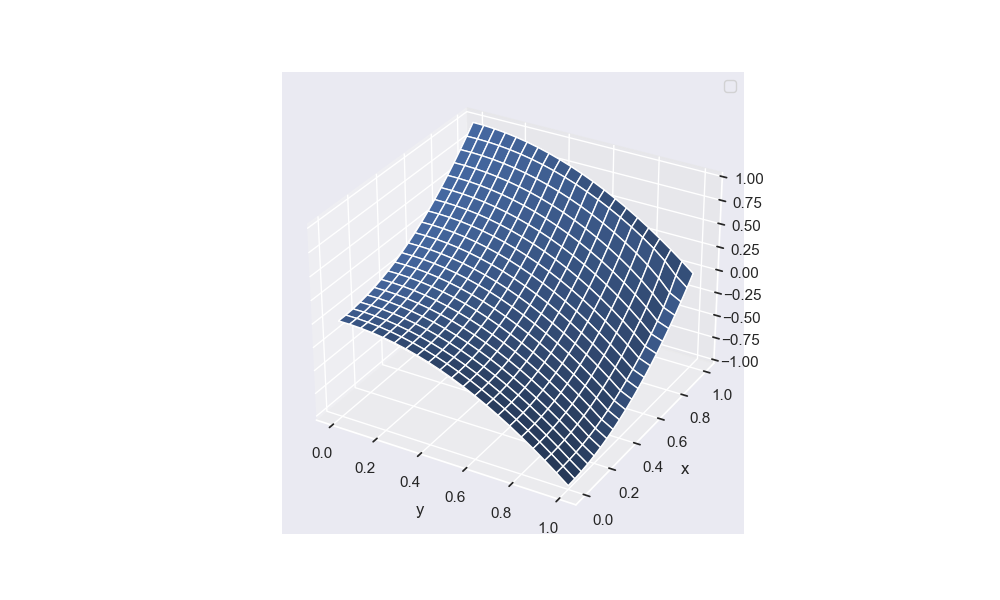

In [18]:
plot_surface(u_exact, u_seidel)

In [19]:
method = LinearAlgebra.Seidel_method
c = 0.3
eps = 1e-5

u_relaxation, k_relaxation = finite_difference_scheme(x_begin, x_end, y_begin, y_end, h_x, h_y, method, eps, c)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


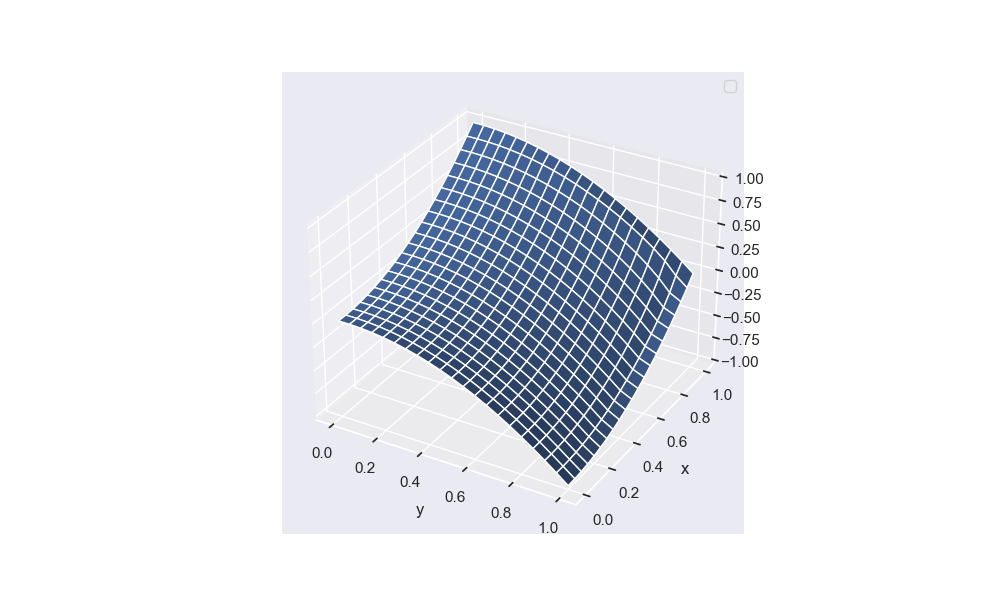

In [20]:
plot_surface(u_exact, u_relaxation)

In [21]:
u_numerical = [u_iterations, u_seidel, u_relaxation]
iterations = [k_iterations, k_seidel, k_relaxation]
names = ['Simple iterations method', 'Seidel method', 'Relaxation Method']

print(f'Gauss method :')
print(f'max abs error = {np.max(abs(u_exact - u_np))}')
print(f'mean abs error = {np.mean(abs(u_exact - u_np))} \n')

for u, iteration, name in zip(u_numerical, iterations, names):
    print(f'{name}:')
    print(f'max abs error = {np.max(abs(u_exact - u))}')
    print(f'mean abs error = {np.mean(abs(u_exact - u))}')
    print(f'iterations = {iteration} \n')

Gauss method :
max abs error = 0.05271889135652741
mean abs error = 0.009450547481441456 

Simple iterations method:
max abs error = 0.05272619328879191
mean abs error = 0.009470020862204312
iterations = 282 

Seidel method:
max abs error = 0.05272149499314349
mean abs error = 0.009452081112906623
iterations = 155 

Relaxation Method:
max abs error = 0.05272266349212196
mean abs error = 0.009453445087143294
iterations = 207 



## Вывод

В данной работе я научился решать краевые задачи для ДУ эллиптического типа с помощью конечно-разностной схемы.

После применения конечно-разностной схемы мы получаем систему уравнений, которую можно решать несколькими методами. Я использовал:
* метод простых итераций
* метод Зейделя
* метод верхних релаксаций